In [1]:
latex_dir = 'LaTex/img/'
EXPORT_FOR_LATEX = True

def plot_images(plot, figname=None):
    if EXPORT_FOR_LATEX:
        plt.savefig(latex_dir+figname+'.pdf', bbox_inches='tight')
    else:
        plot.show()

In [2]:
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from theano import shared

from scipy import stats

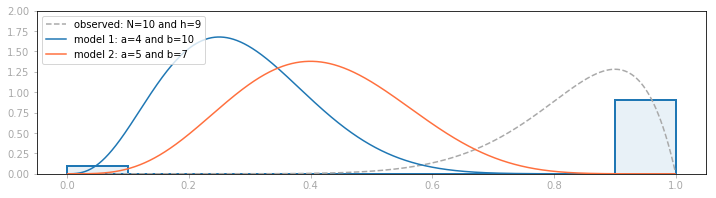

In [3]:
def binomial_p(thetas, N, head):
    return np.power(thetas,head)*np.power(1-thetas,N-head)


a1,b1= 4,10
a2,b2= 5,7
N,h = 10,9
dist_in = np.arange(.001,.999,.0001)

plt.figure(figsize=(12,3))

beta_m1 = stats.beta(a1,b1)
beta_m2 = stats.beta(a2,b2)
dist_m1 = beta_m1.pdf(dist_in)
dist_m2 = beta_m2.pdf(dist_in)

likelihood = stats.bernoulli(h/N)
dist_out = likelihood.rvs(len(dist_in))
weights = np.ones_like(dist_out)/float(len(dist_out))
plt.hist(dist_out, color='#e8f1f7', edgecolor = '#1f77b4',linewidth=2, align='mid', weights=weights)
plt.tick_params(axis='both', colors='darkgrey')

bin_p = binomial_p(dist_in,N,h)
z=bin_p.sum()/dist_out.sum()
bin_p_norm = bin_p/z/3
plt.plot(dist_in,bin_p_norm,'--', color='darkgrey', label='observed: N='+str(N)+' and h='+str(h))


plt.plot(dist_in,dist_m1/2,color='#1f77b4', label='model 1: a='+str(a1)+' and b='+str(b1))
plt.plot(dist_in,dist_m2/2,color='#FF703E', label='model 2: a='+str(a2)+' and b='+str(b2))
plt.tick_params(axis='x', colors='darkgrey')
plt.legend(loc=2)
plt.ylim(0,2)
plot_images(plt, '4_25')

In [4]:
from scipy.special import betaln

def beta_log(h,N,a,b):
    return np.exp(betaln(a + h, b+N-h)-betaln(a, b))

BF = beta_log(h,N,a1,b1)/beta_log(h,N,a2,b2)
print('bayes factor m1/m2:',BF)
print('bayes factor m2/m1:',1/BF)

bayes factor m1/m2: 0.135516657256
bayes factor m2/m1: 7.37916666667


In [5]:
print('m1 likelihood:',BF*100/(1+BF),'%')
print('m2 likelihood:',1/BF*100/(1+1/BF),'%')

m1 likelihood: 11.9343610144 %
m2 likelihood: 88.0656389856 %


In [6]:
y = np.repeat([0, 1], [N-h,h])  # 3 tails 6 heads

with pm.Model() as model:
    model_choice = pm.Bernoulli('choice', p=.5)

    alpha = pm.Deterministic('alpha', pm.math.switch(pm.math.eq(model_choice, 0), a1, a2))
    beta = pm.Deterministic('beta',pm.math.switch(pm.math.eq(model_choice, 0), b1, b2))

    theta = pm.Beta('theta', alpha, beta) # theta distributed as beta density
    y = pm.Bernoulli('y', theta, observed=y)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step)

logp = -11.132, ||grad|| = 5.7143: 100%|████████████████████████████████████████████████| 6/6 [00:00<00:00, 472.91it/s]
100%|██████████████████████████████████████████████████████████████████████████| 10500/10500 [00:04<00:00, 2565.84it/s]


In [7]:
print('sampled likelihood m1:',100-trace[model_choice].mean()*100,'%')
print('sampled likelihood m2:',trace[model_choice].mean()*100,'%')

sampled likelihood m1: 12.06 %
sampled likelihood m2: 87.94 %


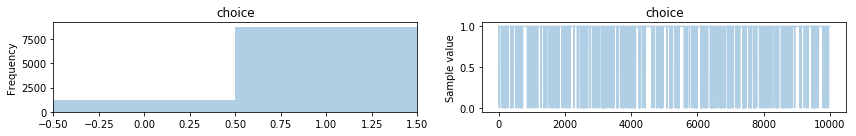

In [10]:
plot_images(pm.traceplot(trace, varnames=['choice']), '4_26')

# entropy

In [16]:
def entropy(p_vect):
    return -np.sum(np.log(p_vect)*p_vect)

In [17]:
entropy([.01,.99])

0.056001534354847345

In [18]:
entropy([.5,.5])

0.69314718055994529

# KL divergence

In [9]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider 
import scipy.stats as st

In [21]:
def kl_div(approx,observed):
    return (observed*np.log(.1+(observed)/approx)).sum()

In [22]:
def interact_plot(mu,sd):
    a = st.norm(mu,sd)
    real = st.gamma(8,4)
    z = np.linspace(-20,30,4000)
    a_pdf = a.pdf(z)
    real_pdf = real.pdf(z)
    
    plt.figure(figsize=(14,5))
    plt.plot(z,a_pdf, label='approx with mu:'+str(mu)+' and sd:'+str(sd))
    plt.plot(z,real_pdf)
    plt.text(-10,.03,str(np.round(kl_div(a_pdf,real_pdf),2)),size=100, alpha=.1)
    plt.legend(loc=3)
    plt.show()

In [23]:
interact(interact_plot, 
         mu=FloatSlider(min=-10,max=30,step=.1,value=10),
        sd=FloatSlider(min=.1,max=10,step=.1,value=3))

A Jupyter Widget

<function __main__.interact_plot>

# kl approximation

In [24]:
def kl_div_approx(p_vect,q_vect):
    return np.sum((np.log(p_vect)-np.log(q_vect))*p_vect)

a = [.7,.3]
b = [.01,.99]
print('a has high entropy:',entropy(a))
print('b has low entropy:',entropy(b))

print('from high to low:',kl_div_approx(a,b))
print('from low to high:',kl_div_approx(b,a))

a has high entropy: 0.610864302055
b has low entropy: 0.0560015343548
from high to low: 2.61576992889
from low to high: 1.13949829137
